In [4]:
import numpy as np
import pandas as pd
import datetime as dt
from numpy.random import rand
import matplotlib.pylab as plt
from sklearn import svm

def RandSmplSeq(data, n_minutes, m_samples):
    rng = data.index[-1] - data.index[0]
    
    for i in range(0, m_samples):
        indx = rand() * rng + data.index[0]
        smp = data.loc[indx:indx+n_minutes]        
        yield smp        

def ReverseArrangement(smp, dirn=1):
    """
    smp assumed to be ordered
    """
    
    # "A" from the murray paper
    if dirn > 0:
        A = [ np.sum(smp.values[i+1:,:] > smp.values[i,:], axis=0) for i in range(0, smp.shape[0]-2)]
    else:
        A = [ np.sum(smp.values[i+1:,:] < smp.values[i,:], axis=0) for i in range(0, smp.shape[0]-2)]
                 
    return np.atleast_1d(np.sum(A, axis=0))
       
# Imagine I censored the data
data = pd.read_csv("~/data/esp_data_one_month_10_minute_interval.csv")

# update index to minutes since epoch
index = np.array([(dt.datetime.strptime(i, "%m/%d/%y %H:%M") - 
                    dt.datetime(1970,1,1)).total_seconds()/60 for i in data['DateTime'] ], 
                       dtype=np.int64)
data.index = index
data.drop('DateTime', 1, inplace=True)


# I'm going to use this supposing it's good
RAseq = []
for i in RandSmplSeq(data, 600, 2000):
    x = ReverseArrangement(i,dirn=1)    
    if(len(x) == 21):
        RAseq.append(x)    
result_noseq = np.vstack(RAseq)

# final 10-hours going to suppose that this was bad
smp = data.iloc[-60:]
x = ReverseArrangement(smp)
last = x*4/(60.*59)

# just fake it 'til we make it:
result_failed = []
for i in range(0, 100):
    result_failed.append(last + np.random.randn(21)*0.1)

# maybe these are good indicators of failure
PCAS = 9
PINP = 10

pcas = np.append([i[PCAS] for i in result_noseq], [i[PCAS] for i in result_failed])
pinp = np.append([i[PINP] for i in result_noseq], [i[PINP] for i in result_failed])

inputs = np.vstack((pcas, pinp)).T
klass = np.append(np.ones(result_noseq.shape[0]), -np.ones(len(result_failed)))

# we probably should have compact support 
poly_svc = svm.SVC(kernel='rbf').fit(inputs, klass)



In [5]:
# how well does it perform:
test = np.array([poly_svc.predict([[last[PCAS] + np.random.randn() * 0.1, last[PINP] + 
                                                 np.random.randn()]])[0] for i in range(0,100)])


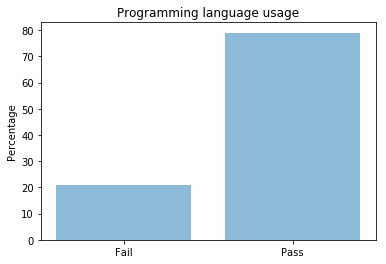

In [6]:



plt.bar([1,0], [np.sum(test < 0), np.sum(test>0)], align='center', alpha=0.5)
plt.xticks([1,0], ["Pass", "Fail"])
plt.ylabel('Percentage')
plt.title('Programming language usage')
plt.show()

